# Extra Trees

## Load Packages and Prep Data

In [19]:
# custom utils
import utils
print(utils.__file__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

In [20]:
ExtraTreesClassifier?

Init signature:
ExtraTreesClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=False,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
An extra-trees classifier.

This class implements a meta estimator that fits a number of
randomized decision trees (a.k.a. extra-trees) on various sub-samples
of the dataset and uses averaging to improve the predictive accuracy
and control over-fitting.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.

    .. versionchanged:: 0.22
       The default value of ``n_estimators`` changed from 10 to 100
       in 0.22.

criterion : {"gin

In [21]:
# load data
X_train, y_train, X_test, y_test = utils.load_data()

(62889, 46)
(15723, 46)


## Model 1
- Defaults

In [25]:
# fit extra trees model
et_1 = ExtraTreesClassifier(random_state=10)
x = et_1.fit(X_train, y_train)

In [26]:
# cross validation with f1 scoring
score = utils.f1_cv(et_1, X_train, y_train)

[0.6955 0.697  0.7003 0.6767 0.686 ]
0.6911


## Model 2
- Bootstrapping

In [27]:
# enable bootstrap
et_2 = ExtraTreesClassifier(oob_score=True, random_state=10, bootstrap=True)
x = et_2.fit(X_train, y_train)

In [28]:
# cross validation with f1 scoring
score = utils.f1_cv(et_2, X_train, y_train)

[0.6856 0.6901 0.6919 0.6725 0.6681]
0.6816


## Model 3
- Grid search hyperparameters

In [29]:
# grid search
param_grid={
        'n_estimators': [*range(10,200,10)],
        'max_depth':[*range(10,200,10), None],
        'min_samples_leaf': [*range(2,16,1), None],
        'min_samples_split': [*range(2,16,1), None],
}

gs = GridSearchCV(ExtraTreesClassifier(),
                param_grid,
                scoring='f1_macro',
                cv=5,
                n_jobs=-1
    )
gs.fit(X_train, y_train)

print(gs.best_params_)
print(gs.best_score_)

# store best model
et_3 = gs.best_estimator_

In [ ]:
# cross validation with f1 scoring
score = utils.f1_cv(et_3, X_train, y_train)

## Test Performance

In [ ]:
# test the performance of the selected model
y_pred = et_3.predict(X_test)

# scores
utils.pred_metrics(y_test, y_pred)

# confusion matrix
utils.cm_plot(y_test,y_pred)

## Insights

In [15]:
feature = pd.DataFrame({"feature":list(X_train.columns), "importance": list(et_1.feature_importances_)})
feature = feature.sort_values("importance", ascending = False).reset_index(drop = True)
feature

,feature,importance
0,transparency,0.216319
1,thick_trans_prod,0.084689
2,fiber_length,0.042183
3,fiber_width,0.038876
4,rnd_ell_prod,0.028567
5,concavity,0.024165
6,solidity,0.023508
7,extent,0.022653
8,angularity,0.021630
9,circularity,0.020907


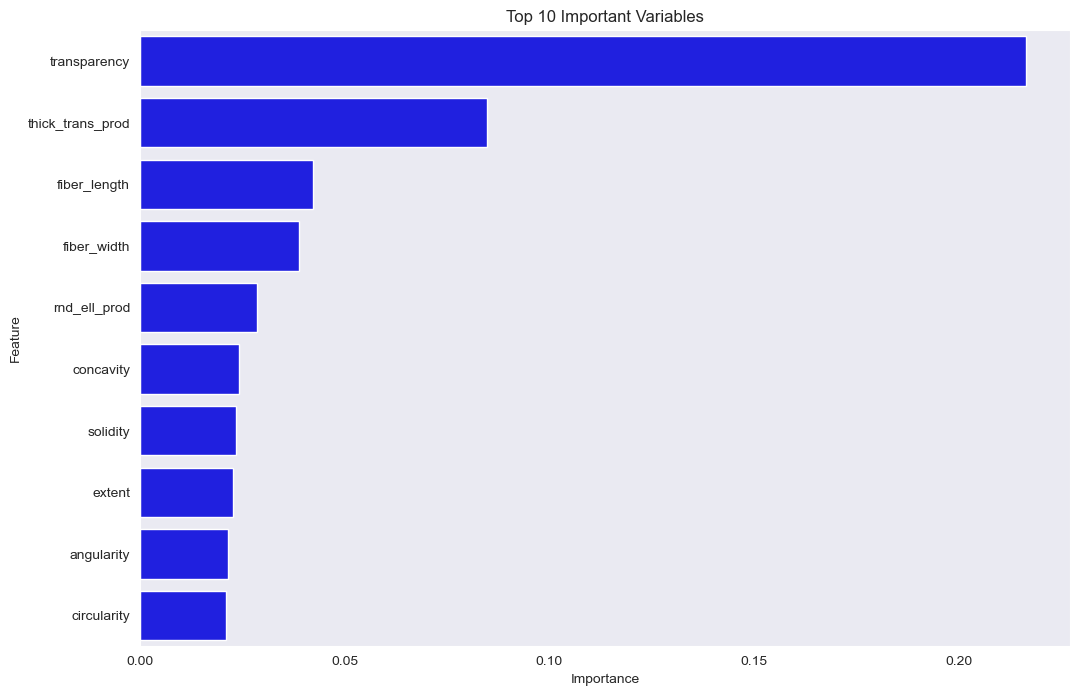

In [17]:
feature_list = feature.loc[:9,["feature", "importance"]]

plt.figure(figsize = (12,8))
sns.barplot(data = feature_list, x = "importance", y = "feature", color = "blue")
plt.title("Top 10 Important Variables")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

### Commentary
This section assesses the reasonableness of the top ten important variables in our model. Overall it appears that the variables measured as important to the model make sense. There are logical reasons backed up by visualizations in our exploratory data analysis that these features would do a good job distinguishing between soil and stone.
- **Transparency** is the mean light intensity of the longest vertical line analyzed. In our exploratory data analysis, the distribution of transparency was the more different between soil and stone than for any other variable. It therefore makes sense that it would be an important variable in distinguishing soil from stone.
- **Thickness Transparency Interaction** (thick_trans_prod) is an attempted encoding of the interaction we discovered between thickness and transparency during our exploratory data analysis. It appeared that, as particles became thicker, the difference in transparency increased.
- **Fiber Length** and **Fiber Width** are measure of linear dimension. By eye, it was hard to see a difference in the stone/soil distribution of these variables. My investigation would be required to assess whether this is a reasonable important variable.
- **Roundness Ellipticity Interaction** (rnd_ell_prod) is another attempted encoding of an interaction. This one is between roundness and ellipticity. In our exploratory data analysis, it appeared that soil particals had a roundness to ellipticity ratio that was either very high or very low. Stone particles tended to be somewhere in the middle.
- **Solidity** is a measure of surface roughness. Higher values describe a smooth surface. Logically, small stone shards might be rougher than soft soil.
- **Concavity** is another measure of surface roughness. Higher values are rough and spikey. It makes sense that the stone particles might be spikey and sharp compared to soil.
- **Extent** = Area / (FLength x FWidth). Value of 1 describes the degree to which the actual area takes up maximum possible area based on product of the two largest perpendicular dimensions. Here, again our exploratory data analysis showed that soil had a larger extent than stone.
- **Angularity** is a measure of protrusions and sharp angles such as abrasives. Although the shape of their distributions was similar, soil particles had a higher density at very low angularity.
- **Roundness** is another shape indicator. Higher values are assigned to circle-like objects. In this case, soil is rounder.